In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import requests
from rdflib import Graph, Namespace, RDF
from ontopy import get_ontology

# Loading from web
battery = get_ontology('https://w3id.org/emmo/domain/battery/inferred').load()   

Loaded data from https://raw.githubusercontent.com/BattGenie/battetl/main/tests/data/arbin_cycler_data/cccv_data_files/BG_Arbin_TestData_CCCV_Cell_2_Channel_26_Wb_1.CSV


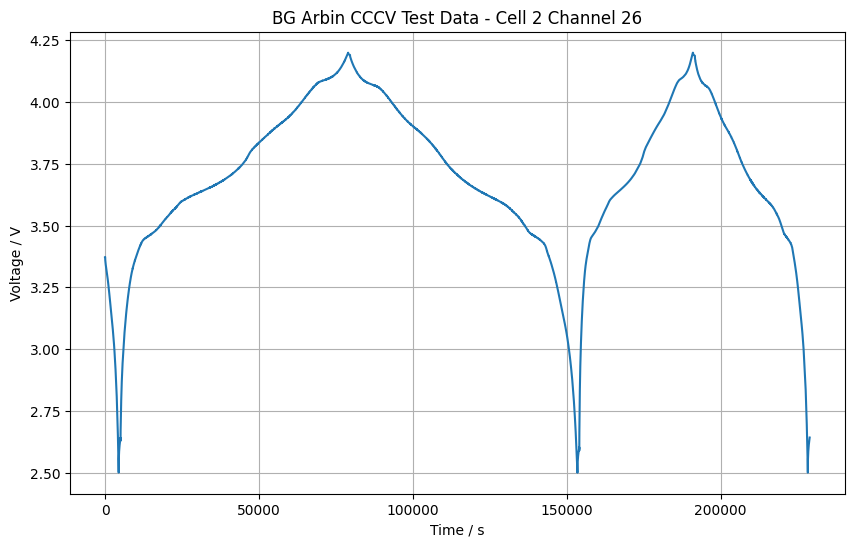

Loaded data from https://raw.githubusercontent.com/BattGenie/battetl/main/tests/data/maccor_cycler_data/simple_data/BG_Maccor_Testdata%20-%20079.txt


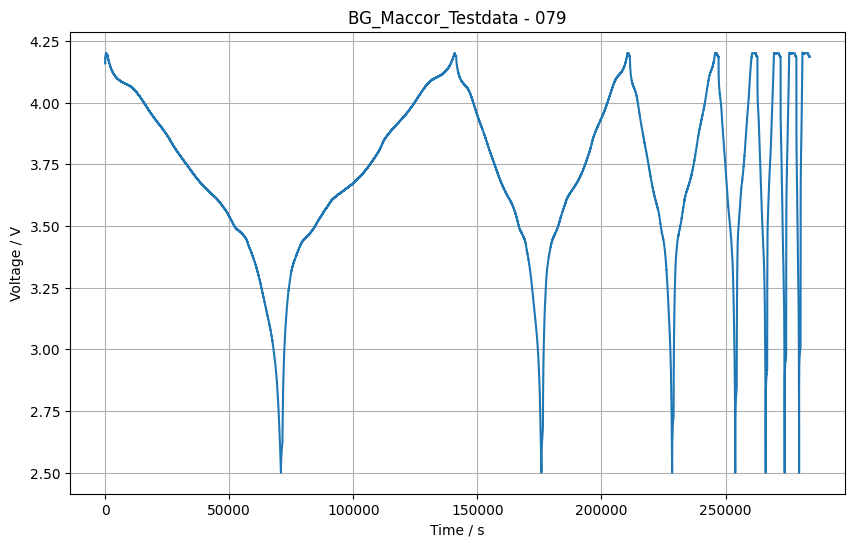

In [19]:
def load_metadata(metadata_file):
    with open(metadata_file, 'r') as f:
        metadata = json.load(f)
    return metadata

def parse_metadata(metadata):
    g = Graph()
    g.parse(data=json.dumps(metadata), format='json-ld')
    #print(f"Number of triples in the graph after parsing metadata: {len(g)}")
    return g

def query_datasets(graph):
    query = """
    PREFIX dcat: <http://www.w3.org/ns/dcat#>
    PREFIX csvw: <http://www.w3.org/ns/csvw#>
    PREFIX dc: <http://purl.org/dc/terms/>

    SELECT ?dataset ?csv_url ?table_schema_url ?title ?delimiter ?skipRows
    WHERE {
        ?dataset a dcat:Dataset ;
                 csvw:url ?csv_url ;
                 csvw:tableSchema ?table_schema_url ;
                 dc:title ?title .
        OPTIONAL {
            ?dataset csvw:dialect ?dialect .
            ?dialect csvw:delimiter ?delimiter .
            ?dialect csvw:skipRows ?skipRows .
        }
    }
    """
    return graph.query(query)

def fetch_table_schema(url):
    response = requests.get(url)
    if response.status_code == 200:
        try:
            return response.json()
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON from {url}: {e}")
    else:
        print(f"Error fetching table schema from {url}: HTTP {response.status_code}")
    return None

def parse_table_schema(graph, table_schema):
    graph.parse(data=json.dumps(table_schema), format='json-ld')
    schema_query = """
    PREFIX csvw: <http://www.w3.org/ns/csvw#>
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

    SELECT ?column_name ?ontology_term
    WHERE {
        ?column csvw:propertyUrl ?property_url ;
                csvw:name ?column_name .
        ?property_url rdf:type ?ontology_term .
    }
    """
    return graph.query(schema_query)

def plot_voltage_time_data(data, time_column, voltage_column, title):
    plt.figure(figsize=(10, 6))
    plt.plot(data[time_column], data[voltage_column])
    plt.xlabel('Time / s')
    plt.ylabel('Voltage / V')
    plt.title(title)
    plt.grid(True)
    plt.show()

def process_file(metadata_file):
    metadata = load_metadata(metadata_file)
    graph = parse_metadata(metadata)
    results = query_datasets(graph)
    #print(f"Number of results: {len(results)}")

    for row in results:
        dataset, csv_url, table_schema_url, title, delimiter, skip_rows = row
        if csv_url and table_schema_url:
            delimiter = delimiter if delimiter else ','  # Default to comma if no delimiter specified
            skip_rows = int(skip_rows) if skip_rows else 0  # Default to 0 if no skipRows specifiedt
            data = pd.read_csv(csv_url, delimiter=delimiter, skiprows=skip_rows)
            print(f"Loaded data from {csv_url}")
            #print(data.head())
            
            table_schema = fetch_table_schema(table_schema_url)
            
            if table_schema:
                schema_results = parse_table_schema(graph, table_schema)
                
                column_mappings = {str(row.ontology_term): str(row.column_name) for row in schema_results}

                time_column = column_mappings.get(battery.TestTime.iri)
                voltage_column = column_mappings.get(battery.CellVoltage.iri)

                if time_column and voltage_column:
                    plot_voltage_time_data(data, time_column, voltage_column, title)

# Run the workflow with a specified metadata file
process_file("BG_Arbin_TestData_CCCV_Cell_2_Channel_26_Wb_1.metadata.json")
process_file("BG_Maccor_Testdata - 079.metadata.json")

In [4]:
import json
import graphviz
from IPython.display import display


In [3]:
import json
import graphviz
from IPython.display import display

# JSON-LD data
jsonld_data = """
{
    "@context": "https://w3id.org/emmo/domain/battery/context",
    "@graph": [
        {
            "@type": "Graphite",
            "@id": "_graphite"
        },
        {
            "@type": "SiliconOxide",
            "@id": "_silicon_oxide"
        },
        {
            "@type": "LithiumNickelManganeseCobaltOxide",
            "@id": "_nmc",
            "molecularFormula": "LiNi0.83Mn0.05Co0.12O2"
        },
        {
            "@type": "Electrolyte",
            "@id": "_electroylte",
            "hasSolvent": {
                "@type": "MySolvent",
                "@id": "_solvent"
            },
            "hasSolute": {
                "@type": "MySolute",
                "@id": "_solute"
            }
        },
        {
            "@type": "Lithium",
            "@id": "_lithium"
        }
    ]
}
"""

# Parse JSON-LD data
data = json.loads(jsonld_data)

# Initialize graphviz Digraph
dot = graphviz.Digraph(comment='JSON-LD Graph', format='png')

# Add nodes and edges to the graph
for entry in data["@graph"]:
    entry_id = entry.get("@id", entry.get("@type", ""))
    dot.node(entry_id, label=entry.get("@type", entry_id))
    
    for key, value in entry.items():
        if isinstance(value, dict) and "@id" in value:
            dot.edge(entry_id, value["@id"], label=key)

# Render the graph to a file
output_path = "rdf_graph"
dot.render(output_path)

# Display the graph
display(dot)


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [7]:
import json
import graphviz
from IPython.display import display

# JSON-LD data
jsonld_data = """
{
    "@context": "https://w3id.org/emmo/domain/battery/context",
    "@graph": [
        {
            "@type": "Graphite",
            "@id": "_graphite"
        },
        {
            "@type": "SiliconOxide",
            "@id": "_silicon_oxide"
        },
        {
            "@type": "LithiumNickelManganeseCobaltOxide",
            "@id": "_nmc",
            "molecularFormula": "LiNi0.83Mn0.05Co0.12O2"
        },
        {
            "@type": "Electrolyte",
            "@id": "_electroylte",
            "hasSolvent": {
                "@type": "MySolvent",
                "@id": "_solvent"
            },
            "hasSolute": {
                "@type": "MySolute",
                "@id": "_solute"
            }
        },
        {
            "@type": "Lithium",
            "@id": "_lithium"
        }
    ]
}
"""

# Parse JSON-LD data
data = json.loads(jsonld_data)

# Initialize graphviz Digraph
dot = graphviz.Digraph(comment='JSON-LD Graph', format='png')

# Add nodes and edges to the graph
for entry in data["@graph"]:
    entry_id = entry.get("@id", entry.get("@type", ""))
    dot.node(entry_id, label=entry.get("@type", entry_id))
    
    for key, value in entry.items():
        if isinstance(value, dict) and "@id" in value:
            dot.edge(entry_id, value["@id"], label=key)

# Render the graph to a file
output_path = "rdf_graph"
dot.render(output_path)

# Display the graph
display(dot)



ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [8]:

import os
import json
import graphviz
from IPython.display import display

# Set the path to the Graphviz executables (adjust the path if needed)
os.environ[r"C:\Users\John\Desktop\import"] += os.pathsep + r'C:\Program Files\Graphviz\bin'

# JSON-LD data
jsonld_data = """
{
    "@context": "https://w3id.org/emmo/domain/battery/context",
    "@graph": [
        {
            "@type": "Graphite",
            "@id": "_graphite"
        },
        {
            "@type": "SiliconOxide",
            "@id": "_silicon_oxide"
        },
        {
            "@type": "LithiumNickelManganeseCobaltOxide",
            "@id": "_nmc",
            "molecularFormula": "LiNi0.83Mn0.05Co0.12O2"
        },
        {
            "@type": "Electrolyte",
            "@id": "_electroylte",
            "hasSolvent": {
                "@type": "MySolvent",
                "@id": "_solvent"
            },
            "hasSolute": {
                "@type": "MySolute",
                "@id": "_solute"
            }
        },
        {
            "@type": "Lithium",
            "@id": "_lithium"
        }
    ]
}
"""

# Parse JSON-LD data
data = json.loads(jsonld_data)

# Initialize graphviz Digraph
dot = graphviz.Digraph(comment='JSON-LD Graph', format='png')

# Add nodes and edges to the graph
for entry in data["@graph"]:
    entry_id = entry.get("@id", entry.get("@type", ""))
    dot.node(entry_id, label=entry.get("@type", entry_id))
    
    for key, value in entry.items():
        if isinstance(value, dict) and "@id" in value:
            dot.edge(entry_id, value["@id"], label=key)

# Render the graph to a file
output_path = "rdf_graph"
dot.render(output_path)

# Display the graph
display(dot)


KeyError: 'C:\\Users\\John\\Desktop\\import'

In [9]:
import os

# Print the PATH environment variable
print("PATH environment variable:")
print(os.environ["PATH"])


PATH environment variable:
c:\Users\John\Desktop\import\Pybop\Scripts;C:\Users\John\Desktop\import\Pybop\Scripts;C:\WINDOWS\system32;C:\WINDOWS;C:\WINDOWS\System32\Wbem;C:\WINDOWS\System32\WindowsPowerShell\v1.0\;C:\WINDOWS\System32\OpenSSH\;C:\Program Files\Polyspace\R2020b\runtime\win64;C:\Program Files\Polyspace\R2020b\bin;C:\Program Files\Polyspace\R2020b\polyspace\bin;C:\Program Files (x86)\Bitvise SSH Client;C:\Program Files\Wolfram Research\WolframScript\;C:\Users\John\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\Scripts;C:\Users\John\AppData\Local\Microsoft\WindowsApps;C:\Users\John\AppData\Local\GitHubDesktop\bin


In [ ]:
import os
import json
import graphviz
from IPython.display import display

# Print the PATH environment variable
print("PATH environment variable before modification:")
print(os.environ["PATH"])

# Set the path to the Graphviz executables (adjust the path if needed)
os.environ["PATH"] += os.pathsep + r'C:\Program Files\Graphviz\bin'

# Print the PATH environment variable after modification
print("PATH environment variable after modification:")
print(os.environ["PATH"])

# JSON-LD data
jsonld_data = """
{
    "@context": "https://w3id.org/emmo/domain/battery/context",
    "@graph": [
        {
            "@type": "Graphite",
            "@id": "_graphite"
        },
        {
            "@type": "SiliconOxide",
            "@id": "_silicon_oxide"
        },
        {
            "@type": "LithiumNickelManganeseCobaltOxide",
            "@id": "_nmc",
            "molecularFormula": "LiNi0.83Mn0.05Co0.12O2"
        },
        {
            "@type": "Electrolyte",
            "@id": "_electroylte",
            "hasSolvent": {
                "@type": "MySolvent",
                "@id": "_solvent"
            },
            "hasSolute": {
                "@type": "MySolute",
                "@id": "_solute"
            }
        },
        {
            "@type": "Lithium",
            "@id": "_lithium"
        }
    ]
}
"""

# Parse JSON-LD data
data = json.loads(jsonld_data)

# Initialize graphviz Digraph
dot = graphviz.Digraph(comment='JSON-LD Graph', format='png')

# Add nodes and edges to the graph
for entry in data["@graph"]:
    entry_id = entry.get("@id", entry.get("@type", ""))
    dot.node(entry_id, label=entry.get("@type", entry_id))
    
    for key, value in entry.items():
        if isinstance(value, dict) and "@id" in value:
            dot.edge(entry_id, value["@id"], label=key)

# Render the graph to a file
output_path = "rdf_graph"
dot.render(output_path)

# Display the graph
display(dot)
